## Import data and Pre-Processing

In [232]:
import pandas as pd
import numpy as np

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


data = pd.read_csv("UsArrests.csv")
data.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [233]:
# See how many feature and how many rows/entries there are
print('Number of entries: {} Number of features: {}'.format(data.shape[0],data.shape[1]))

Number of entries: 50 Number of features: 5


In [234]:
#Check for missing values
missing = data.isnull().sum()
missing_data = pd.DataFrame(missing, columns=["missing"])
missing_data

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [235]:
# confirm any missing value would be picked up (e.g. check for ' ' being used for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [236]:
# Check for inconsistencies in recording of data
city_sorted =data.sort_values('City', ascending=False)
city_sorted['City'].unique() 

array(['Wyoming', 'Wisconsin', 'West Virginia', 'Washington', 'Virginia',
       'Vermont', 'Utah', 'Texas', 'Tennessee', 'South Dakota',
       'South Carolina', 'Rhode Island', 'Pennsylvania', 'Oregon',
       'Oklahoma', 'Ohio', 'North Dakota', 'North Carolina', 'New York',
       'New Mexico', 'New Jersey', 'New Hampshire', 'Nevada', 'Nebraska',
       'Montana', 'Missouri', 'Mississippi', 'Minnesota', 'Michigan',
       'Massachusetts', 'Maryland', 'Maine', 'Louisiana', 'Kentucky',
       'Kansas', 'Iowa', 'Indiana', 'Illinois', 'Idaho', 'Hawaii',
       'Georgia', 'Florida', 'Delaware', 'Connecticut', 'Colorado',
       'California', 'Arkansas', 'Arizona', 'Alaska', 'Alabama'],
      dtype=object)

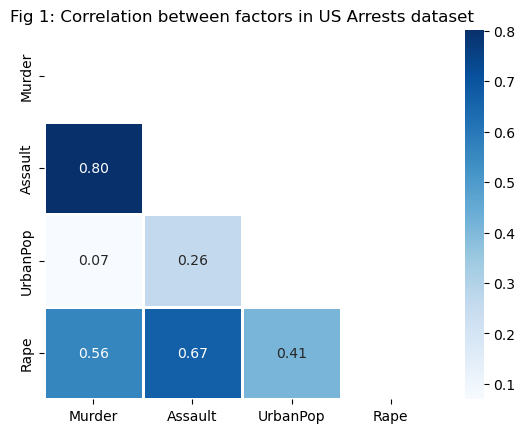

In [237]:
# Check for any key correlations in the dataset
correlations_data = data.drop(["City"],axis=1).corr()
labels =correlations_data.columns
mask_ut=np.triu(np.ones(correlations_data.shape))
sns.heatmap(correlations_data, mask=mask_ut, cmap="Blues", annot=True, fmt=".2f", linewidth=2).set(title="Fig 1: Correlation between factors in US Arrests dataset");


## Initial Findings
- No missing values found in the dataset
- City names have been entered correctly - no inconsistencies seen
- Correlation analysis:
    - Urban population: Almost no correlation seen between population and murder, and low correlation between population and assualt. Contrastingly, there is a positive correlation seen between population and rape
    - Strongest correlation is seen between murder and assault 
    - Rape shows a relatively strong positive correlation with all of the features in the dataset
    - Strong correlations between features e.g. murder and assault makes this dataset suitable for PCA to remove redundancies
    

## Principal Components Analysis (PCA)

In [238]:
data = data.set_index('City')
x = data.values.squeeze()

# Scale data in variable x
x_std = StandardScaler().fit_transform(x)

In [239]:
std_pca = PCA()
std_principal_components = std_pca.fit_transform(x_std)

df_std_pca = pd.DataFrame(std_principal_components)
df_std_pca.head()


,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


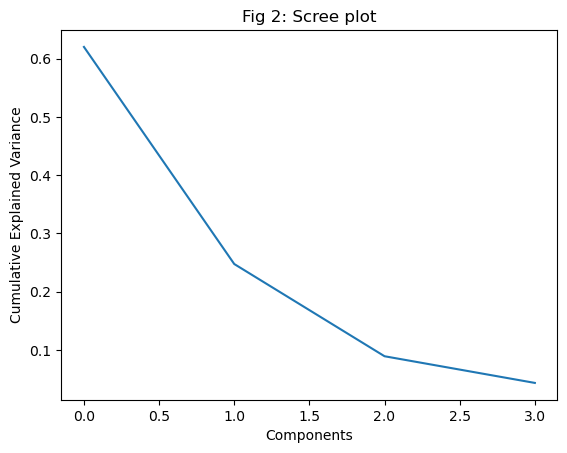

In [240]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('Components')
plt.ylabel('Cumulative Explained Variance')
plt.title("Fig 2: Scree plot");


# Reference:
# https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d#:~:text=If%20our%20sole%20intention%20of,variables%20in%20the%20original%20dataset.

The above scree plot shows >80% of variance is explained by PCs: 0, 1 and 2 and so nm_components will be set to 3

In [241]:
num_comps = 3
pca_comps = PCA(n_components=num_comps)

principal_components = pca_comps.fit_transform(x_std)
pca_data = pd.DataFrame(principal_components, index = data.index)

pca_data.head()

,0,1,2
City,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


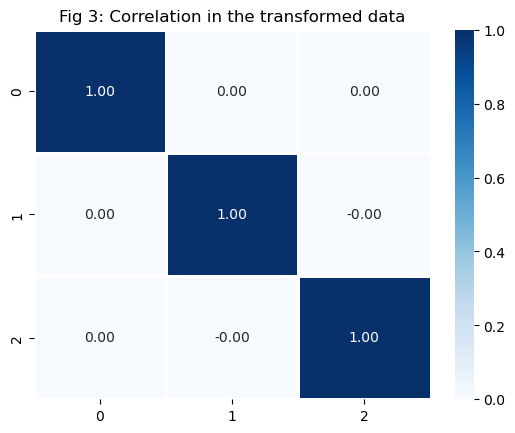

In [242]:
ax = sns.heatmap(pca_data.corr(), cmap='Blues', annot=True, fmt=".2f", linewidth=1).set(title="Fig 3: Correlation in the transformed data")

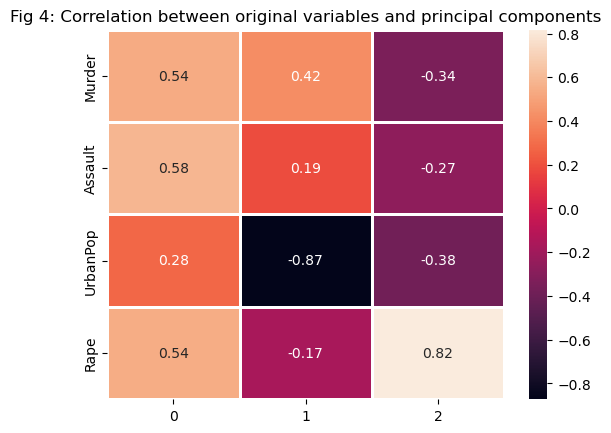

In [243]:
# Plot the original components against the principal components
components = pd.DataFrame(pca_comps.components_, columns=data.columns).transpose()
ax = sns.heatmap(components, annot=True, fmt=".2f", linewidth=1).set(title="Fig 4: Correlation between original variables and principal components")  

## PCA review/findings
- Based on scree plot, >80% of variance can be explained by 3x components
- Using PCA model with number of components set to 3 removes redundancies (shown in Fig 3)
- When comparing original variables to principal components we can see the strong correlations that have been removed

## Cluster Analysis
### 1. KMeans Clustering

In [244]:
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state =12)
    kmeans_pca.fit(pca_data)
    wcss.append(kmeans_pca.inertia_)

# reference:
# Within-Cluster Sum of Square (WCSS): https://365datascience.com/tutorials/python-tutorials/pca-k-means/
    

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


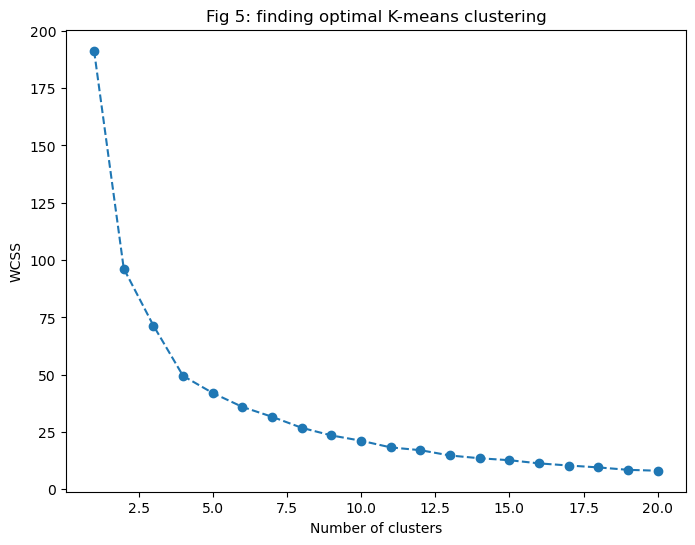

In [245]:
plt.figure(figsize = (8,6))
plt.plot(range(1,21), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Fig 5: finding optimal K-means clustering')
plt.show()

Based on the above, optimal number of clusters is 4 so this will be used in model

In [246]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=12)
kmeans_pred = kmeans.fit_predict(principal_components)

score = round(silhouette_score(principal_components, kmeans.labels_, metric='euclidean'),2)
print(f'Silhouette Ccore: {score}')



Silhouette Ccore: 0.37


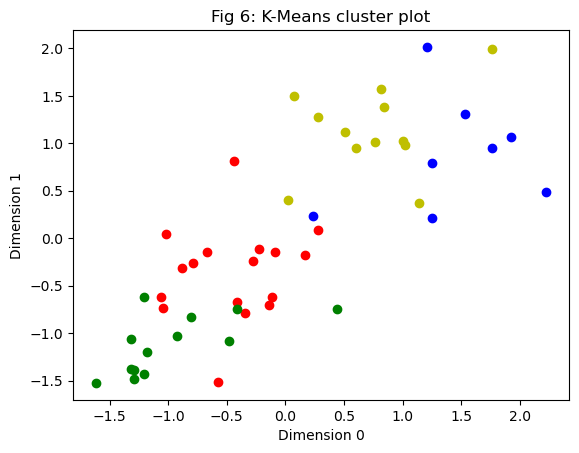

In [249]:
x = x_std[:,0].reshape(-1,1)
y = x_std[:,1].reshape(-1,1)


#plot graph of clusters
def kmeans_graph(x,y):
    fig, ax = plt.subplots()
    colours = 'rgby'
    for i in range(0,4):
        ax.scatter(x[kmeans_pred == i],y[kmeans_pred == i],c = colours[i]) 
    ax.set_title("Fig 6: K-Means cluster plot")
    ax.set_xlabel(f'Dimension 0')
    ax.set_ylabel(f'Dimension 1')
    
kmeans_graph(x,y)

### 2. Hierarchical clustering

### Complete vs Average

<Figure size 2000x3000 with 0 Axes>

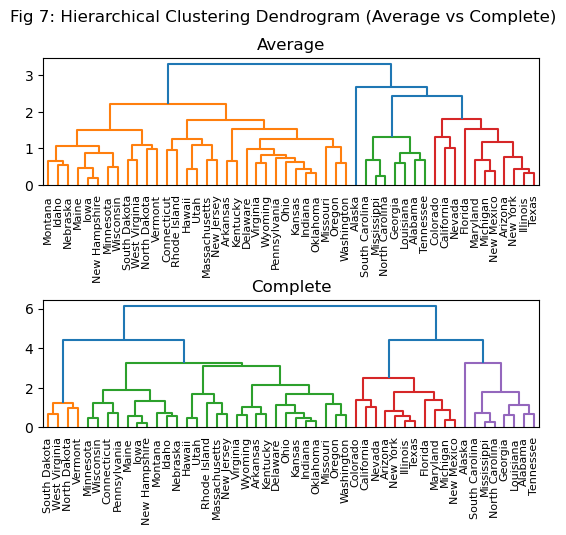

In [252]:
fig = plt.figure(figsize=(20,30))
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.9)
fig.suptitle('Fig 7: Hierarchical Clustering Dendrogram (Average vs Complete)')
ax1.set_title("Average")
dendrogram(linkage(pca_data, method='average'), labels=pca_data.index, ax=ax1)
ax2.set_title("Complete")
dendrogram(linkage(pca_data, method='complete'), labels=pca_data.index, ax=ax2);
# Reference for formatting help:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html#sphx-glr-gallery-images-contours-and-fields-irregulardatagrid-py

### Euclidean vs Cityblock

<Figure size 2000x3000 with 0 Axes>

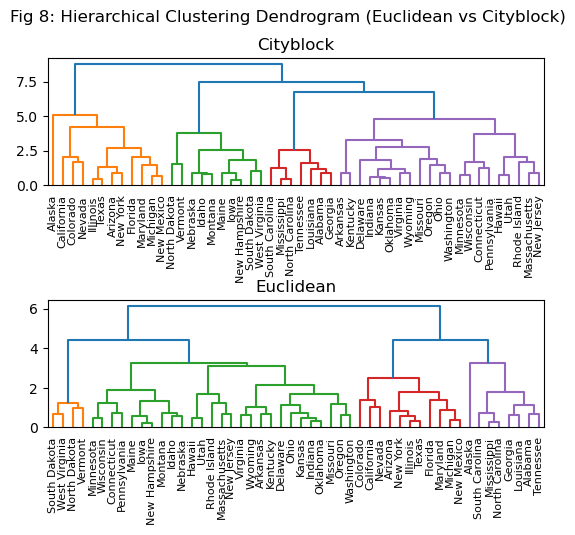

In [254]:
fig = plt.figure(figsize=(20,30))
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.9)
fig.suptitle('Fig 8: Hierarchical Clustering Dendrogram (Euclidean vs Cityblock)')
ax1.set_title("Cityblock")
dendrogram(linkage(pca_data, method='complete', metric = 'cityblock'),labels=pca_data.index, ax=ax1) 
ax2.set_title("Euclidean")
dendrogram(linkage(pca_data, method='complete', metric = 'euclidean'),labels=pca_data.index, ax=ax2);

### Parameter analysis
- The most suitable parameters for this dataset are cityblock and complete
- both plots here show 4 clusters, which is aligned with Figure 5 in teh Kmeans section

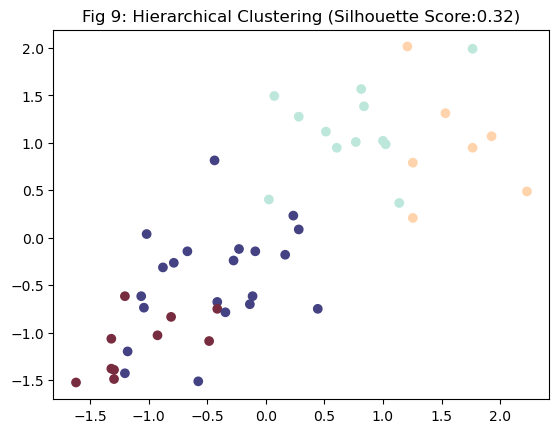

In [258]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='cityblock', linkage='complete')
cluster.fit_predict(pca_data)
plt.scatter(x_std[:,0], x_std[:,1], c=cluster.labels_, cmap = 'icefire')
score = round(silhouette_score(x_std, cluster.labels_),2)
plt.title(f'Fig 9: Hierarchical Clustering (Silhouette Score:{score})');

## Analysis of cluster methods
Kmeans and hierarchical clustering produced similar results:
- Silhouette score: 0.37 for Kmeans and 0.32 for hierarchical.
    - These scores show there is minimal overlap between groups 
- Number of clusters:
    - Both the hierarchical (through dendrograms) and KMeans (through elbow graph) showed 4 clusters was optimal